## ResNet_1x_asymmetric_tanh_pi_4

This repository provides a custom ResNet-style model trained on the CIFAR-10 dataset, demonstrating how to replace standard ReLU activations with a custom hyperbolic tangent (\tanh) function. Specifically:

1.	asymmetric_tanh_pi_4 Module – Implements via its explicit exponential formula for easy modification.
2.	TanhBottleneck Class – Subclasses torchvision.models.resnet.Bottleneck but uses asymmetric_tanh_pi_4 in place of ReLU within each residual block.
3.	ResNetTanh – A custom ResNet that automatically adopts TanhBottleneck blocks, effectively creating a “ResNet-50-like” network with \tanh activations.
4.	Double Depth Option – You can optionally double the number of blocks in each layer (e.g., from [3,4,6,3] to [6,8,12,6]), making the model “twice as deep.”
5.	CIFAR-10 Data Pipeline – Demonstrates loading CIFAR-10, resizing.
6.	Plot and Save – Provides a simple plotting routine for losses and accuracies over epochs, and saves the final model weights to a file.

This code serves as a template for experimenting with custom activations in ResNet architectures on relatively simple datasets like CIFAR-10.

In [1]:
# %% [markdown]
# ## ResNet with Asymmetric π/4 Tanh() 
# 
# This repository provides a custom ResNet-style model trained on the CIFAR-10 dataset, demonstrating how to replace standard ReLU activations with a custom hyperbolic tangent (\tanh) function, then use Captum **Saliency** to visualize explanation maps.

# %%
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import latexify
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.resnet import ResNet, Bottleneck

# Captum: now using Saliency instead of LRP
from captum.attr import Saliency


/opt/anaconda3/envs/pytorch_course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###############################################
# Plot function asymmetric_tanh_pi_4
###############################################
@latexify.function
def CustomTanhPrint(x):
    return (e**(π/4 * x) - e**-x) /( e**x + e**-x)

print(CustomTanhPrint)
CustomTanhPrint


\mathrm{CustomTanhPrint}(x) = \frac{e^{\frac{π}{4} x} - e^{-x}}{e^{x} + e^{-x}}


In [3]:
################################################################################
# 1) Define Custom asymmetric_tanh_pi_4() activation function
################################################################################
class asymmetric_tanh_pi_4(nn.Module):
    """
    Custom Tanh activation using the explicit formula:
        tanh_pi_4 = [ *e^((π/4)*x) - e^-x ] / [ e^x + e^-x ]
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
         return ((np.exp(math.pi/4 * x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

In [4]:
################################################################################
# 2) Define TanhBottleneck Block (Replaces ReLU with asymmetric_tanh_pi_4()
################################################################################
class TanhBottleneck(Bottleneck):
    """
    A ResNet Bottleneck that replaces ReLU with the asymmetric tanh(π/4) activation:
        out = ( e^{(π/4)*out} - e^{-out} ) / ( e^{out} + e^{-out} )
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        # 1) First conv + batchnorm
        out = self.conv1(x)
        out = self.bn1(out)
        # Apply custom tanh with torch.exp
        out = (torch.exp((math.pi/4)*out) - torch.exp(-out)) / (torch.exp(out) + torch.exp(-out))

        # 2) Second conv + batchnorm
        out = self.conv2(out)
        out = self.bn2(out)
        out = (torch.exp((math.pi/4)*out) - torch.exp(-out)) / (torch.exp(out) + torch.exp(-out))

        # 3) Third conv + batchnorm
        out = self.conv3(out)
        out = self.bn3(out)

        # Downsample if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the residual connection
        out += identity

        # Final tanh activation in this block
        out = (torch.exp((math.pi/4)*out) - torch.exp(-out)) / (torch.exp(out) + torch.exp(-out))
        return out
    

################################################################################
# The following code is adapted for LRP analysis
################################################################################

In [5]:
################################################################################
# 3) Create a Custom ResNet Class Using TanhBottleneck
################################################################################
class ResNetTanh(ResNet):
    def __init__(self, layers, num_classes=10):
        super().__init__(
            block=TanhBottleneck,
            layers=layers,
            num_classes=num_classes
        )
    def forward(self, x):
        return super().forward(x)

def resnet50_tanh(double_depth=False, num_classes=10):
    """
    Build a ResNet-50-like model with π/4 Tanh activation.
    - If double_depth=True, doubles each stage from [3,4,6,3] to [6,8,12,6].
    """
    layers = [6, 8, 12, 6] if double_depth else [3, 4, 6, 3]
    return ResNetTanh(layers=layers, num_classes=num_classes)


In [6]:
################################################################################
# 4) Data Loading: CIFAR-10
################################################################################
os.makedirs('./cifar_data', exist_ok=True)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(
    root="./cifar_data",
    train=True,
    download=True,
    transform=transform_train
)
test_dataset = datasets.CIFAR10(
    root="./cifar_data",
    train=False,
    download=True,
    transform=transform_test
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
################################################################################
# 5) Instantiate Model, Loss, Optimizer
################################################################################
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Using device: {device}")

model = resnet50_tanh(double_depth=False, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: mps


In [8]:
################################################################################
# 6) Training & Evaluation Functions
################################################################################
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [9]:
################################################################################
# 7) Main Training Loop
################################################################################
num_epochs = 20  # For demonstration, keep it short
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

Epoch 1/20 Train Loss: 1.8149 Acc: 32.40% | Test Loss: 1.6881 Acc: 36.35%
Epoch 2/20 Train Loss: 1.5376 Acc: 43.25% | Test Loss: 1.6073 Acc: 43.09%
Epoch 3/20 Train Loss: 1.3395 Acc: 51.28% | Test Loss: 1.2832 Acc: 52.50%
Epoch 4/20 Train Loss: 1.1819 Acc: 57.47% | Test Loss: 1.1522 Acc: 57.82%
Epoch 5/20 Train Loss: 1.0559 Acc: 62.26% | Test Loss: 1.2109 Acc: 57.36%
Epoch 6/20 Train Loss: 0.9556 Acc: 66.05% | Test Loss: 0.9375 Acc: 65.99%
Epoch 7/20 Train Loss: 0.8776 Acc: 68.80% | Test Loss: 0.8999 Acc: 67.82%
Epoch 8/20 Train Loss: 0.8113 Acc: 71.28% | Test Loss: 0.8729 Acc: 69.30%
Epoch 9/20 Train Loss: 0.7460 Acc: 73.64% | Test Loss: 0.7954 Acc: 71.56%
Epoch 10/20 Train Loss: 0.6915 Acc: 75.67% | Test Loss: 0.7666 Acc: 73.34%
Epoch 11/20 Train Loss: 0.6405 Acc: 77.56% | Test Loss: 0.7122 Acc: 75.08%
Epoch 12/20 Train Loss: 0.5957 Acc: 79.19% | Test Loss: 0.6692 Acc: 76.97%
Epoch 13/20 Train Loss: 0.5508 Acc: 80.63% | Test Loss: 0.6754 Acc: 77.14%
Epoch 14/20 Train Loss: 0.5115 Acc

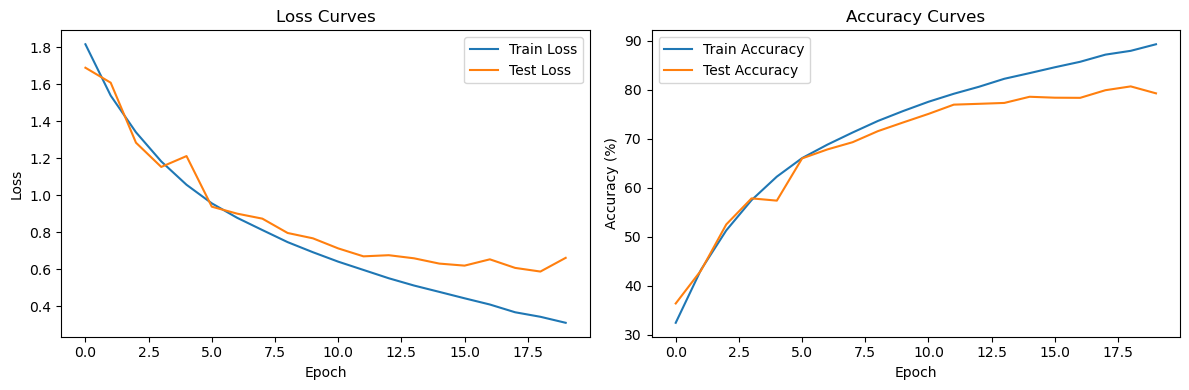

In [10]:
###############################################
# 8) Plot the training curves
###############################################
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
################################################################################
# Save Model Weights
################################################################################
torch.save(model.state_dict(), "resnet50_tanh_pi_4_cifar10.pt")
print("Model saved to resnet50_tanh_cifar10.pt")

Model saved to resnet50_tanh_cifar10.pt


Ground Truth: 0 | Predicted: 0
Ground Truth: 0 | Predicted (index): 0 | Predicted (label): airplane


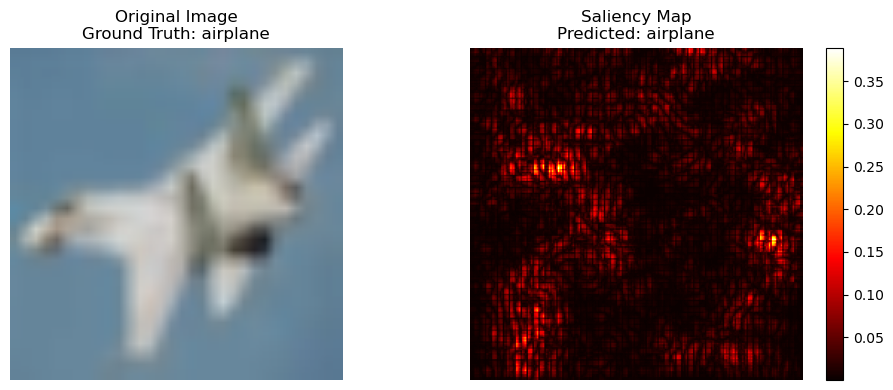

In [37]:
################################################################################
# 9) Saliency Analysis (Captum) - as an alternative to LRP
################################################################################
# We'll compute a saliency map on a single sample from the test set.
saliency = Saliency(model)

# CIFAR-10 class names:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


# Get one batch from the test loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Focus on a single image
img_index = 10  # pick any valid index within the batch <<<<<<<<<<<<<<<<<<<<<!!!!!!!!!!!!!!!!!!!
single_img = images[img_index].unsqueeze(0)   
single_label = labels[img_index].item()

model.eval()
with torch.no_grad():
    output = model(single_img)
predicted_class = output.argmax(dim=1).item()

print("Ground Truth:", single_label, "| Predicted:", predicted_class)


with torch.no_grad():
    output = model(single_img)
predicted_class = output.argmax(dim=1).item()
predicted_label_str = class_names[predicted_class]
print("Ground Truth:", single_label, "| Predicted (index):", predicted_class,
      "| Predicted (label):", predicted_label_str)

# For saliency, we need gradients wrt input:
single_img.requires_grad_()

# Compute saliency attributions for the predicted class
attr = saliency.attribute(single_img, target=predicted_class)  # [1,3,224,224]

# Convert to numpy for visualization
attr = attr.detach().cpu().numpy()[0]  # shape [3,224,224]
attr_sum = np.sum(attr, axis=0)        # sum over the channels => [224,224]

# (A) Show the original image
original_img = single_img[0].detach().cpu().numpy()  # shape [3,224,224]
original_img = np.transpose(original_img, (1,2,0))   # => [224,224,3]

# Denormalize for display
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
original_img = std * original_img + mean
original_img = np.clip(original_img, 0, 1)

plt.figure(figsize=(10,4))

# (A) Original Image
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title(f"Original Image\nGround Truth: {class_names[single_label]}")
plt.axis("off")

# (B) Saliency Map
plt.subplot(1,2,2)
plt.imshow(attr_sum, cmap='hot')
plt.title(f"Saliency Map\nPredicted: {predicted_label_str}")
plt.axis("off")
plt.colorbar()

plt.tight_layout()
plt.show()